In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go
from utils import parse_real_disp, CABC_Displacement, CABC_Force, parse_real_force

torch.set_default_dtype(torch.float64)

# Random Parameter Generation

In [ ]:
# # Bounds
# n_bounds = (0.2, 0.8)
# tau_star_bounds = (10000.0, 80000.0)
# # B_bounds_log = (np.log10(1.0e+14), np.log10(1.916e+19))  # log10 scaling
# tau_w_bounds = (0.005, 1.0)
# m_bounds = (1.0, 1.9)

# # LHs Sampling
# sampler = qmc.LatinHypercube(d=4)
# sample = sampler.random(10)  # 5 samples

# # # Scaling
# n_values = sample[:, 0] * (n_bounds[1] - n_bounds[0]) + n_bounds[0]
# tau_star_values = sample[:, 1] * (tau_star_bounds[1] - tau_star_bounds[0]) + tau_star_bounds[0]
# # B_values = 10 ** (sample[:, 2] * (B_bounds_log[1] - B_bounds_log[0]) + B_bounds_log[0])
# tau_w_values = sample[:, 2] * (tau_w_bounds[1] - tau_w_bounds[0]) + tau_w_bounds[0]
# m_values = sample[:, 3] * (m_bounds[1] - m_bounds[0]) + m_bounds[0]

# # # save2CSV
# df = pd.DataFrame({
#     'n': n_values,
#     'tau_star': tau_star_values,
#     # 'B': B_values,
#     'tau_w': tau_w_values,
#     'm': m_values
# })
# df.to_csv("combined_LHS_parameters.csv", index=False)

# XML Parsing - Master Curve

In [2]:
# Directories
real_disp_path = "H:\\Real_data\\press_displacement_real.xml"
real_force_path = "H:\\Real_data\\press_force_real.xml"

# Force XML

real_force_time, real_force = parse_real_force(real_force_path)

def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)

    # Resample both curves on this time grid
    real_disp_resampled = np.interp(common_time, real_time, real_disp)
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    mse = np.mean((real_disp_resampled-guess_disp_resampled)**2)
    
    return mse

real_data_directory = "H:\\Real_data\\press_force_real.xml"
areas = []
area_data = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []
guess_data_all = {}

count = 0

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    if count >=  27:
        break  # Stop the loop after collecting 27 values

    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

    count += 1

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1]   / 1000

In [ ]:
# file_info = [
#     {
#         "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar03mms388g.txt",  #0
#         "force_start"   : "31.07.2025 10:39:06.150461",
#         "force_end"     : "31.07.2025 10:39:24.070461",
#         "pos_start"     : "31.07.2025 10:39:24.070461",
#         "pos_end"       : "31.07.2025 10:42:34.610461"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar07mms384g.txt",  #1
#         "force_start"   : "31.07.2025 10:18:27.193997",
#         "force_end"     : "31.07.2025 10:18:35.113997",
#         "pos_start"     : "31.07.2025 10:18:35.113997",
#         "pos_end"       : "31.07.2025 10:20:44.573997"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\60percent4STACKBAR150bar11mms414g.txt",  #2
#         "force_start"   : "30.07.2025 13:43:44.197899",
#         "force_end"     : "30.07.2025 13:43:49.057899",
#         "pos_start"     : "30.07.2025 13:43:49.057899",
#         "pos_end"       : "30.07.2025 13:46:49.957899"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar03mms396g.txt", #3
#         "force_start"   : "29.07.2025 15:27:01.321079",
#         "force_end"     : "29.07.2025 15:27:19.181079",
#         "pos_start"     : "29.07.2025 15:27:19.181079",
#         "pos_end"       : "29.07.2025 15:30:46.881079"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar07mms398g.txt", #4
#         "force_start"   : "30.07.2025 12:19:49.167098",
#         "force_end"     : "30.07.2025 12:19:57.487098",
#         "pos_start"     : "30.07.2025 12:19:57.487098",
#         "pos_end"       : "30.07.2025 12:21:55.287098"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\60percent4STACKCENTER150bar11mms393g.txt", #5
#         "force_start"   : "30.07.2025 12:46:38.439119",
#         "force_end"     : "30.07.2025 12:46:43.619119",
#         "pos_start"     : "30.07.2025 12:46:43.619119",
#         "pos_end"       : "30.07.2025 12:50:18.619119"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\60percent4STACKCENTER200bar11mms365g.txt",#6
#         "force_start"   : "31.07.2025 11:00:47.633201",
#         "force_end"     : "31.07.2025 11:00:53.213201",
#         "pos_start"     : "31.07.2025 11:00:53.213201",
#         "pos_end"       : "31.07.2025 11:06:35.493201"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar03mms508g.txt", #7
#         "force_start"   : "30.07.2025 11:47:26.451826",
#         "force_end"     : "30.07.2025 11:47:42.371826",
#         "pos_start"     : "30.07.2025 11:47:42.371826",
#         "pos_end"       : "30.07.2025 11:50:53.831826"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar07mms525g.txt", #8
#         "force_start"   : "31.07.2025 14:21:37.055615",
#         "force_end"     : "31.07.2025 14:21:43.535615",
#         "pos_start"     : "31.07.2025 14:21:43.535615",
#         "pos_end"       : "31.07.2025 14:24:04.975615"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\80percent4STACKBAR150bar11mms531g.txt", #9
#         "force_start"   : "31.07.2025 14:49:31.716399",
#         "force_end"     : "31.07.2025 14:49:35.816399",
#         "pos_start"     : "31.07.2025 14:49:35.816399",
#         "pos_end"       : "31.07.2025 15:01:25.776399"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar03mms542g.txt", #10
#         "force_start"   : "31.07.2025 09:07:08.361246",
#         "force_end"     : "31.07.2025 09:07:23.161246",
#         "pos_start"     : "31.07.2025 09:07:23.161246",
#         "pos_end"       : "31.07.2025 09:09:48.641246"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar07mms527g.txt", #11
#         "force_start"   : "30.07.2025 15:33:47.945013",
#         "force_end"     : "30.07.2025 15:33:54.465013",
#         "pos_start"     : "30.07.2025 15:33:54.465013",
#         "pos_end"       : "30.07.2025 15:36:35.305013"
#     },
#     {
#         "path" : "H:\\DLR Press Data\\80percent4STACKCENTER150bar11mms543g.txt", #12
#         "force_start"   : "31.07.2025 09:56:19.454633",
#         "force_end"     : "31.07.2025 09:56:23.494633",
#         "pos_start"     : "31.07.2025 09:56:23.494633",
#         "pos_end"       : "31.07.2025 09:58:13.974633"  
#     },
#     {
#         "path" : "H:\\DLR Press Data\\SPLITCONF80percent4STACKBAR150bar03mms518g.txt", #13
#         "force_start"   : "31.07.2025 15:16:03.864139",
#         "force_end"     : "31.07.2025 15:16:18.464139",
#         "pos_start"     : "31.07.2025 15:16:18.464139",
#         "pos_end"       : "31.07.2025 15:20:00.584139"  
#     }

# ]

In [ ]:
# # Load the CSV data from the first file_info
# index_master = 10  # or whichever index you want
# master_info = file_info[index_master]

# df_master = pd.read_csv(
#     master_info["path"],
#     encoding='utf-16-le',
#     sep=';',
#     skiprows=1,
#     quotechar='"'
# )

# # Clean and preprocess
# df_master = df_master.rename(columns={
#     'time': 'Time',
#     'dbPr\\diIstKraftGes': 'Force'
# })
# df_master = df_master[['Time', 'Force']]
# df_master['Force'] = df_master['Force'].astype(str).str.replace(',', '.', regex=False)
# df_master['Force'] = pd.to_numeric(df_master['Force'], errors='coerce')
# df_master = df_master[df_master['Time'] != 'sec']
# df_master['Time'] = pd.to_datetime(df_master['Time'], format='%d.%m.%Y %H:%M:%S.%f')

# # Time filter and alignment
# force_start = pd.to_datetime(master_info["force_start"], format='%d.%m.%Y %H:%M:%S.%f')
# force_end = pd.to_datetime(master_info["force_end"], format='%d.%m.%Y %H:%M:%S.%f')
# master_df = df_master[(df_master['Time'] >= force_start) & (df_master['Time'] <= force_end)].copy()
# master_df['Time_seconds'] = (master_df['Time'] - master_df['Time'].iloc[0]).dt.total_seconds()

# # Extract time and force as NumPy arrays
# real_time = master_df['Time_seconds'].to_numpy()
# real_force = master_df['Force'].to_numpy() /  9.80665

# # Optional: resample master curve on a common time grid
# common_time = np.linspace(0.0, real_time.max(), num=200)
# real_force_resampled = np.interp(common_time, real_time, real_force)


In [3]:
df = pd.read_csv('combined_LHS_parameters.csv')

n_values = df['n'].tolist()
tau_star_values = df['tau_star'].tolist()
# B_values = df['B'].tolist()
tau_w_values = df['tau_w'].tolist()
m_values = df['m'].tolist()

# Moldflow Simulation

In [4]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2026\\bin"                        #Home D:\\Moldflow Insight 2023\\bin       #WS "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"  #"G:\\Oskay Sözen\\wall_slip\\wall slip.mpi"


Synergy.OpenProject("G:\\Oskay Sözen\\Parameter\\Parameter.mpi")
Project = Synergy.Project
Project.OpenItemByName("80CENTER_study", "Study")



# # #Simulation loop for wall slip parameters
# for i in range(10):
#     t0 = time.perf_counter()
#     n = n_values[i]
#     tau_star = tau_star_values[i]
#     # B = B_values[i]
#     tau_w = tau_w_values[i]
#     m = m_values[i]


#     print(f"Simulation {i+1} with \nn : {n}\ntau_star : {tau_star}\ntau_w : {tau_w}\nm : {m}")

#     study_name = f"study_{i+1}"
#     Project = Synergy.Project

#     # Viscosity Parameters

#     PropEd = Synergy.PropertyEditor
#     Prop = PropEd.FindProperty(10090,1)
#     Prop.FieldDescription(53030, f"{n}, {tau_star}, 1.916e+6, 0.004, 0, 0, 0.305")
#     PropEd.CommitChanges("Process Conditions")

#     # Wall Slip Parameters

#     PropEd = Synergy.PropertyEditor
#     Prop = PropEd.FindProperty(10090, 1)
#     DVec = Synergy.CreateDoubleArray
    
#     DVec.AddDouble(tau_w)
#     DVec.AddDouble(m)
#     DVec.AddDouble(1e-08)
#     DVec.AddDouble(0)
#     DVec.AddDouble(0)
    
#     Prop.FieldValues(51182, DVec)
        
#     PropEd.CommitChanges("Process Conditions")

#     StudyDoc = Synergy.StudyDoc
#     StudyDoc.SaveAs(study_name)

#     p = subprocess.Popen(
#     [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\Parameter\\study_{i+1}.sdy"],
#     stdout=subprocess.PIPE,
#     stderr=subprocess.STDOUT,
#     )
#     (output, err) = p.communicate()
#     t1 = time.perf_counter(); print("Solver took", t1-t0)
#     time.sleep(3)

#     # Restart of the Synergy to prevent XML saving crash
    
#     subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

#     time.sleep(5)

#     Synergy.OpenProject("G:\\Oskay Sözen\\Parameter\\Parameter.mpi")         # PROJECT NAME!!!!!!!!!!!!!!!!
#     Project = Synergy.Project
#     Project.OpenItemByName(f"study_{i+1}", "Study")

#     # Plot Export

#     PlotMgr = Synergy.PlotManager
#     time.sleep(3)
#     Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
#     Pid = Plot.GetDataID
#     PlotMgr = None
#     PlotMgr = Synergy.PlotManager
#     time.sleep(3)
#     PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\study_{i + 1}.xml", "Metric")
#     t2 = time.perf_counter(); print("XML took", t2-t1)
# # Write the output to a log file
#     with open(f"H:\\Log_Files\\study_{i+1}.log", "w") as file:
#         file.write(output.decode("windows-1252").strip())



True

# XML Parsing - Guess Curves

In [5]:
guess_disp_data_all = {}
guess_force_data_all = {}
area_data = []
guess_data_all = {}

valid_xml = []
for i in range(10):
        guess_tree = ET.parse(f"H:\\XMLFiles\\study_{i + 1}.xml")
        guess_root = guess_tree.getroot()
        guess_data = []

        count = 0
                
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
                if count >= 30:
                        break


                time_value = time_block.attrib.get('Value')
                dept_value = dept_block.find('DeptValues').text.strip()
                
                guess_data.append((time_value, dept_value))

                count += 1
        if len(guess_data) < 30:
                print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
                continue

        guess_data_all[f"guess_data_{i+1}"] = guess_data

        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1] * 9.80665

        globals()[f"guess_time_{i+1}"] = guess_time
        globals()[f"guess_disp_{i+1}"] = guess_disp 


        mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
        area_data.append(mean_s_error)
        valid_xml.append(len(area_data) - 1)

        
print(guess_data_all)

{'guess_data_1': [('0.002574', '2.2930e+00'), ('0.041172', '1.6410e+00'), ('0.322550', '2.2887e+00'), ('0.745501', '2.3673e+00'), ('1.126146', '2.6595e+00'), ('1.429310', '3.6819e+00'), ('1.796299', '1.2954e+01'), ('2.079389', '1.4126e+01'), ('2.434584', '1.4714e+01'), ('2.887878', '1.5541e+01'), ('3.264068', '1.6613e+01'), ('3.568892', '1.7559e+01'), ('3.920182', '1.8442e+01'), ('4.206748', '1.9425e+01'), ('4.584613', '2.0393e+01'), ('4.887459', '2.1580e+01'), ('5.239764', '2.2905e+01'), ('5.523669', '2.5264e+01'), ('5.834966', '2.9310e+01'), ('6.137529', '4.0502e+01'), ('6.410882', '4.9608e+01'), ('6.679507', '5.3110e+01'), ('6.936635', '5.5917e+01'), ('7.074174', '6.4344e+01'), ('7.149768', '1.1868e+02'), ('7.178360', '1.4239e+02'), ('7.184859', '1.4200e+02'), ('7.188359', '1.4200e+02'), ('7.189359', '1.4200e+02'), ('7.191360', '1.4200e+02')], 'guess_data_2': [('0.002574', '2.8975e+00'), ('0.045178', '2.2801e+00'), ('0.355761', '3.1863e+00'), ('0.698280', '3.2608e+00'), ('1.109225',

In [6]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[np.float64(18928.77133050996), np.float64(20243.904851410032), np.float64(328308.0438612676), np.float64(9814.09821792706), np.float64(2788.480869154951), np.float64(58980.57386895382), np.float64(10162.904295633145), np.float64(85133.62627918331), np.float64(130917.03767009871), np.float64(130853.40100184083)]
['guess_data_1', 'guess_data_2', 'guess_data_3', 'guess_data_4', 'guess_data_5', 'guess_data_6', 'guess_data_7', 'guess_data_8', 'guess_data_9', 'guess_data_10']
guess_data_1: Shape = (30, 2)
guess_data_2: Shape = (30, 2)
guess_data_3: Shape = (30, 2)
guess_data_4: Shape = (30, 2)
guess_data_5: Shape = (30, 2)
guess_data_6: Shape = (30, 2)
guess_data_7: Shape = (30, 2)
guess_data_8: Shape = (30, 2)
guess_data_9: Shape = (30, 2)
guess_data_10: Shape = (30, 2)


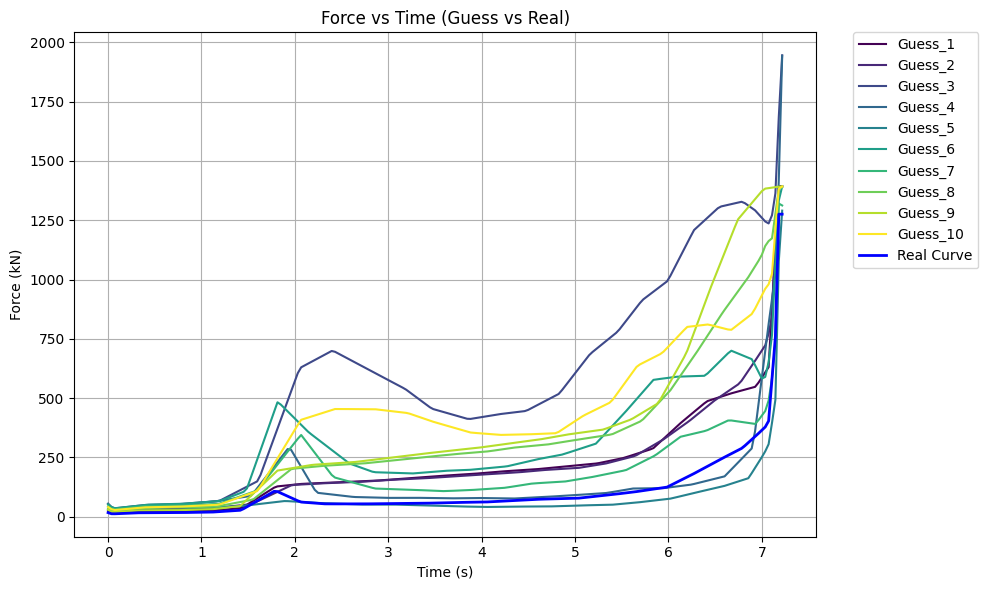

In [7]:
common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)
real_force_resampled = np.interp(common_time, real_time, real_disp)

num_curves = len(guess_data_all)
colormap = plt.get_cmap('viridis')

plt.figure(figsize=(10, 6))

for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_force = guess_data_array[:, 1] * 9.80665

    guess_force_resampled = np.interp(common_time, guess_time, guess_force)
    color = colormap((i - 1) / max(num_curves - 1, 1))
    plt.plot(common_time, guess_force_resampled, color=color, label=f'Guess_{i}')

plt.plot(common_time, real_force_resampled, 'b-', label='Real Curve', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
plt.title('Force vs Time (Guess vs Real)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


# GP Model

In [10]:
file_path = 'H:\\moldflow\\moldflow_automation\\combined_LHS_parameters.csv'
data = pd.read_csv(file_path)
n_values = data['n'].values
tau_star_values = data['tau_star'].values
# B_values = data['B'].values
tau_w_values = data['tau_w'].values
m_values = data['m'].values

train_x = torch.tensor([[n_values[i], tau_star_values[i], tau_w_values[i], m_values[i]] for i in valid_xml ], dtype=torch.float64)
train_y = - torch.tensor([[area_data[i]] for i in valid_xml], dtype=torch.float64)
train_yvar = torch.full_like(train_y, 1e-6)



# bounds = torch.tensor([
#     [0.2, 10000.0, 0.005, 1.0],
#     [0.8, 80000.0, 1.0, 1.9]
# ], dtype= torch.float64
# )

# outcome_transform = Standardize(m=1)
# input_transform = Normalize(d=4)

# # GP Model 
# model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
# mll = ExactMarginalLogLikelihood(model.likelihood, model)
# fit_gpytorch_mll(mll)
# model.eval()  


# acq_func =  LogExpectedImprovement(model, best_f=train_y.max().item())

# candidate, _ = optimize_acqf(
#         acq_function=acq_func,
#         bounds=bounds,
#         q=1,
#         num_restarts=1000, #Helps to ensure that we find the global optimum instead of finding the local optimum
#         raw_samples=5000,  #More samples increases likelihood of finding good starting point.
# )

# cand = model(input_transform(candidate))
# cand_var = torch.diagonal(cand.covariance_matrix, 0)
# cand_mean, cand_std = outcome_transform.untransform(cand.mean, cand_var)


In [ ]:
print(candidate)
print(train_y)
print(train_x)
bounds.shape

# Optimization CHECK CANDIDATE


In [ ]:
guess_data_all_optim = {}
num_iteration = 30
iterations=[]

for i in range(num_iteration):
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=4)

    model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()  

    acq_func =  LogExpectedImprovement(model, best_f=train_y.max())


    candidate_optim, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts=100, #Helps to ensure that we find the global optimum instead of finding the local optimum
            raw_samples=5000,  #More samples increases likelihood of finding good starting point.
    )

    print(f"Iteration {i+1}: Suggested new parameters (n, tau_star, B, tau_w, m)", candidate_optim)
    iterations.append(candidate_optim)

    study_name = f"optimization_{i+1}"
    Project = Synergy.Project

    # Viscosity Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090,1)
    Prop.FieldDescription(53030, f"{candidate_optim[0,0].item()}, {candidate_optim[0,1].item()}, 1.916e+6, 0.004, 0, 0, 0.305")
    PropEd.CommitChanges("Process Conditions")

    # Wall Slip Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(candidate_optim[0,2].item())
    DVec.AddDouble(candidate_optim[0,3].item())
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
        
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\Parameter\\optimization_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()

    time.sleep(2)

    Synergy.OpenProject("G:\\Oskay Sözen\\Parameter\\Parameter.mpi")         # PROJECT NAME!!!!!!!!!!!!!!!!
    Project = Synergy.Project
    Project.OpenItemByName(f"optimization_{i+1}", "Study")

    # Plot Export

    PlotMgr = Synergy.PlotManager
    time.sleep(2)
    Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(2)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\optimization_{i + 1}.xml", "Metric")



# Write the output to a log file
    with open(f"H:\\Log_Files\\optimization_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

    guess_tree = ET.parse(f"H:\\XMLFiles\\optimization_{i+1}.xml")
    guess_root = guess_tree.getroot()
    guess_data = []
    time.sleep(1) 
    count = 0   
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
        if count >= 30:
            break
        
        time_value = time_block.attrib.get('Value')
        dept_value = dept_block.find('DeptValues').text.strip()
        guess_data.append((time_value, dept_value))

        count += 1
    if len(guess_data) < 30:
        print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
        continue
    guess_data_all_optim[f"guess_data_{i+1}"] = guess_data

    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]  
    guess_disp = guess_data_array[:, 1]  * 9.80665
        
    globals()[f"guess_time_{5 + num_iteration}"] = guess_time
    globals()[f"guess_disp_{5 + num_iteration}"] = guess_disp
    
    mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
    area_data.append(mean_s_error)
    valid_xml.append(len(area_data) - 1)

    # New Values

    train_x = torch.cat([train_x, candidate_optim], dim=0)
    train_y = torch.cat([train_y, -torch.tensor([[area_data[-1]]])], dim=0)
    train_yvar = torch.full_like(train_y, 1e-6)

    current_best_area = train_y.max().item()

    if abs(current_best_area) < 1e-2:
        print(f"Converged after {i+1} iteration")
        break
    
best_params = train_x[train_y.argmax()]
best_area = train_y.max().item()
print(f"Best parameters (n, tau_star, B, tau_w, m): {best_params}, with MSE : {best_area}")





In [ ]:
num_curves = len(guess_data_all)
colormap = plt.get_cmap('viridis')

plt.figure(figsize=(10, 6))

for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_force = guess_data_array[:, 1] * 9.80665

    guess_force_resampled = np.interp(common_time, guess_time, guess_force)
    color = colormap((i - 1) / max(num_curves - 1, 1))
    plt.plot(common_time, guess_force_resampled, color=color, label=f'Guess_{i}')

plt.plot(common_time, real_force_resampled, 'b-', label='Real Curve', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')
plt.title('Force vs Time (Guess vs Real)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

num_curves = len(guess_data_all_optim)
colormap = plt.get_cmap('viridis', num_curves)  
plt.plot(common_time, guess_force_resampled, 'b-', label='Real Curve')
for i, (key, guess_data) in enumerate(guess_data_all_optim.items()):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]

        guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

        color = colormap(i) 
        plt.plot(common_time, guess_disp_resampled, color=color, label=f'Guess_{i+1}')

# Finalize plot
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Force vs Time (Optimized Curves)')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()  
plt.show()

In [11]:
import torch

# === Define real parameter bounds (raw) ===
real_bounds = torch.tensor([
    [0.2, 10000.0, 0.005, 1.0],
    [0.8, 80000.0, 1.0, 1.9]
], dtype=torch.float64)

# === Define normalized bounds for acquisition optimizer ===
normalized_bounds = torch.stack([torch.zeros(4), torch.ones(4)], dim=0)

# === Unnormalize helper function ===
def unnormalize(x_normalized, bounds):
    lower, upper = bounds[0], bounds[1]
    return lower + (upper - lower) * x_normalized

# === Optimization Loop ===
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

import subprocess
import xml.etree.ElementTree as ET
import time
import numpy as np

guess_data_all_optim = {}
iterations = []
num_iteration = 30

for i in range(num_iteration):
    # === Build GP Model ===
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=4)

    model = SingleTaskGP(
        train_x, train_y, train_Yvar=train_yvar,
        outcome_transform=outcome_transform,
        input_transform=input_transform
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()

    # === Acquisition Function ===
    acq_func = LogExpectedImprovement(model, best_f=train_y.max())

    # === Optimize Acquisition in Normalized Space ===
    candidate_normalized, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=normalized_bounds,
        q=1,
        num_restarts=50,
        raw_samples=2000,
    )

    # === Unnormalize to real-world values for simulation ===
    candidate_unnormalized = unnormalize(candidate_normalized, real_bounds)

    print(f"Iteration {i+1}: Suggested parameters", candidate_unnormalized)
    iterations.append(candidate_unnormalized)

    # === Extract values ===
    n = candidate_unnormalized[0, 0].item()
    tau_star = candidate_unnormalized[0, 1].item()
    tau_w = candidate_unnormalized[0, 2].item()
    m = candidate_unnormalized[0, 3].item()

    # === Send values to Moldflow ===
    study_name = f"optimization_{i+1}"
    Project = Synergy.Project

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    Prop.FieldDescription(53030, f"{n}, {tau_star}, 1.916e+6, 0.004, 0, 0, 0.305")
    PropEd.CommitChanges("Process Conditions")

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    DVec.AddDouble(tau_w)
    DVec.AddDouble(m)
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    Prop.FieldValues(51182, DVec)
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    # === Run simulation ===
    p = subprocess.Popen(
        [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\Parameter\\optimization_{i+1}.sdy"],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    time.sleep(2)

    Synergy.OpenProject("G:\\Oskay Sözen\\Parameter\\Parameter.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"optimization_{i+1}", "Study")

    # === Export Result to XML ===
    PlotMgr = Synergy.PlotManager
    time.sleep(2)
    Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(2)
    PlotMgr.SaveResultDataInXML2(Pid, f"H:\\XMLFiles\\optimization_{i + 1}.xml", "Metric")

    # === Save log output ===
    with open(f"H:\\Log_Files\\optimization_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

    # === Parse XML ===
    guess_tree = ET.parse(f"H:\\XMLFiles\\optimization_{i+1}.xml")
    guess_root = guess_tree.getroot()
    guess_data = []

    count = 0
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
        if count >= 30:
            break
        time_value = time_block.attrib.get('Value')
        dept_value = dept_block.find('DeptValues').text.strip()
        guess_data.append((time_value, dept_value))
        count += 1

    if len(guess_data) < 30:
        print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
        continue

    guess_data_all_optim[f"guess_data_{i+1}"] = guess_data

    # === Convert and Evaluate ===
    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]
    guess_disp = guess_data_array[:, 1] * 9.80665

    mse = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
    area_data.append(mse)
    valid_xml.append(len(area_data) - 1)

    # === Add to training data ===
    train_x = torch.cat([train_x, candidate_unnormalized], dim=0)
    train_y = torch.cat([train_y, -torch.tensor([[mse]], dtype=torch.float64)], dim=0)
    train_yvar = torch.full_like(train_y, 1e-6)

    # === Check convergence ===
    if abs(train_y.max().item()) < 1e-2:
        print(f"Converged after {i+1} iterations.")
        break

# === Final result ===
best_params = train_x[train_y.argmax()]
best_mse = -train_y.max().item()
print(f"\n✅ Best Parameters: {best_params}")
print(f"🎯 Best MSE: {best_mse}")


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 1: Suggested parameters tensor([[3.0205e-01, 6.5647e+04, 9.4458e-01, 1.7372e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 2: Suggested parameters tensor([[2.9624e-01, 7.9616e+04, 8.9737e-01, 1.6980e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 3: Suggested parameters tensor([[2.3930e-01, 7.8073e+04, 7.8570e-01, 1.8884e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 4: Suggested parameters tensor([[2.2711e-01, 7.6961e+04, 7.7822e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 5: Suggested parameters tensor([[2.8235e-01, 7.7171e+04, 9.2411e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 6: Suggested parameters tensor([[2.8121e-01, 7.5275e+04, 9.4268e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 7: Suggested parameters tensor([[2.9540e-01, 7.4283e+04, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 8: Suggested parameters tensor([[2.9555e-01, 7.8579e+04, 1.0000e+00, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 9: Suggested parameters tensor([[4.2406e-01, 7.2944e+04, 1.1576e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 10: Suggested parameters tensor([[4.4022e-01, 7.9393e+04, 1.1373e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 11: Suggested parameters tensor([[4.5343e-01, 7.8368e+04, 1.1107e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 12: Suggested parameters tensor([[4.5916e-01, 7.9695e+04, 1.1079e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 13: Suggested parameters tensor([[4.3356e-01, 8.0000e+04, 2.2899e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 14: Suggested parameters tensor([[4.2860e-01, 7.8671e+04, 1.8974e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 15: Suggested parameters tensor([[4.2499e-01, 7.5408e+04, 1.6847e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 16: Suggested parameters tensor([[4.2035e-01, 7.9362e+04, 1.4867e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 17: Suggested parameters tensor([[4.1550e-01, 7.7029e+04, 1.2448e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 18: Suggested parameters tensor([[4.1062e-01, 7.9996e+04, 1.1013e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 19: Suggested parameters tensor([[4.1073e-01, 7.8054e+04, 1.1259e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 20: Suggested parameters tensor([[4.2310e-01, 8.0000e+04, 1.5280e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 21: Suggested parameters tensor([[4.3507e-01, 7.5562e+04, 2.3230e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 22: Suggested parameters tensor([[4.3476e-01, 7.8078e+04, 2.2971e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 23: Suggested parameters tensor([[4.3456e-01, 7.9808e+04, 2.2807e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 24: Suggested parameters tensor([[4.3446e-01, 7.8100e+04, 2.2722e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 25: Suggested parameters tensor([[4.3443e-01, 7.5575e+04, 2.2703e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 26: Suggested parameters tensor([[4.3462e-01, 7.9274e+04, 2.2856e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 27: Suggested parameters tensor([[4.3547e-01, 5.0898e+04, 2.3360e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 28: Suggested parameters tensor([[4.3522e-01, 7.9606e+04, 2.3353e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 29: Suggested parameters tensor([[4.3520e-01, 7.9446e+04, 2.3390e-01, 1.9000e+00]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iteration 30: Suggested parameters tensor([[4.3515e-01, 1.9227e+04, 2.3462e-01, 1.9000e+00]])

✅ Best Parameters: tensor([4.2499e-01, 7.5408e+04, 1.6847e-01, 1.9000e+00])
🎯 Best MSE: 2330.696332448991


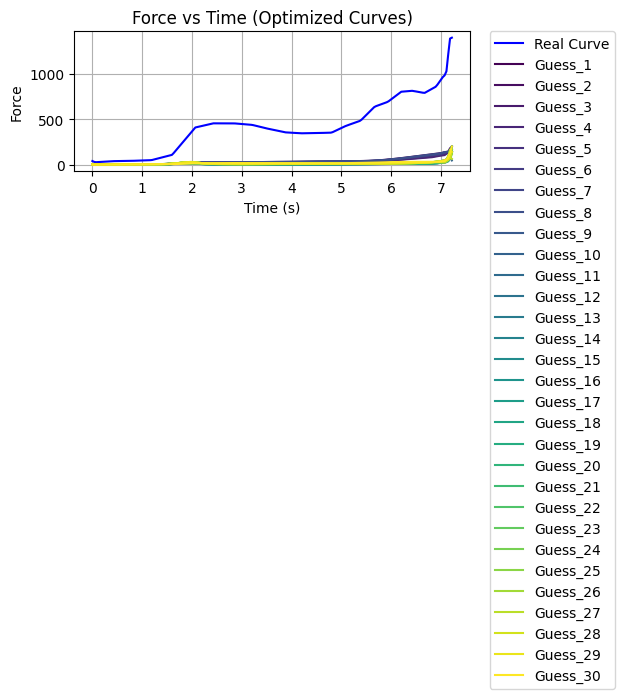

In [12]:

num_curves = len(guess_data_all_optim)
colormap = plt.get_cmap('viridis', num_curves)  
plt.plot(common_time, guess_force_resampled, 'b-', label='Real Curve')
for i, (key, guess_data) in enumerate(guess_data_all_optim.items()):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]

        guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

        color = colormap(i) 
        plt.plot(common_time, guess_disp_resampled, color=color, label=f'Guess_{i+1}')

# Finalize plot
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Force vs Time (Optimized Curves)')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()  
plt.show()